# Producing training dataset and reference free-energy profile calculation for the solvated bistable dimer 

In [1]:
import scipy
import numpy as np
import tensorflow as tf

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16, 'savefig.dpi': 300, 'savefig.bbox': 'tight'})
results_dir = "../results/bistable_dimer/"

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from energy_models.particle_dimer import ParticleDimer
from sampling import MetropolisGauss, UmbrellaModel, UmbrellaSampling, HungarianMapper

In [5]:
# Create model
params = ParticleDimer.default_params.copy()
params['dimer_slope'] = 2.0
model = ParticleDimer(params=params)
print(model.params)

{'n_solvent': 36, 'eps': 1.0, 'rm': 1.1, 'dimer_slope': 2.0, 'dimer_a': 25.0, 'dimer_b': 10.0, 'dimer_dmid': 1.5, 'dimer_k': 20.0, 'box_halfsize': 3.0, 'box_k': 100.0, 'grid_k': 0.0}


## Plot dimer energy profile

(-2.0, 22.0)

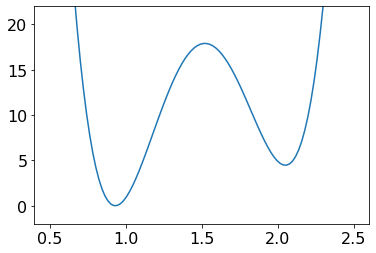

In [6]:
x_scan = np.linspace(0.5, 2.5, 100)
E_scan = model.dimer_energy(np.array([1.5-0.5*x_scan, np.zeros(100), 1.5+0.5*x_scan, np.zeros(100)]).T)
E_scan -= E_scan.min()
plt.plot(x_scan, E_scan)
plt.ylim(-2, 22)

## Test plotting of system state

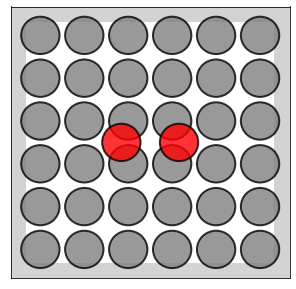

In [7]:
model.draw_config(1.05*model.init_positions(1.5), dimer_color='red', alpha=0.8)

## Estimate time to get single transition by MC simulation

This section is only for informative purposes and can be skipped.

In [8]:
params

{'n_solvent': 36,
 'eps': 1.0,
 'rm': 1.1,
 'dimer_slope': 2.0,
 'dimer_a': 25.0,
 'dimer_b': 10.0,
 'dimer_dmid': 1.5,
 'dimer_k': 20.0,
 'box_halfsize': 3.0,
 'box_k': 100.0,
 'grid_k': 0.0}

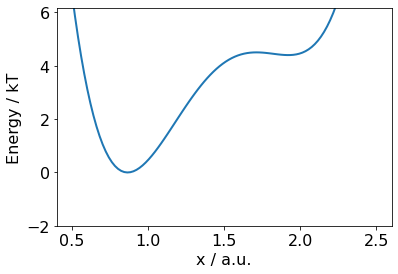

In [9]:
# Change barrier but keep a/b
params_flat = params.copy()
params_flat['dimer_a'] = 1.1 * 2.5
params_flat['dimer_b'] = 1.1
model_flat = ParticleDimer(params=params_flat)
model_flat.plot_dimer_energy();

In [10]:
N_steps = 1000000
x0 = model.init_positions(0.7)
sampler = MetropolisGauss(model_flat, x0, sigma_metro=0.02, burn_in=10000, stride=100)
sampler.run(N_steps, verbose=100000)

Step 0 / 1000000
Step 100000 / 1000000
Step 200000 / 1000000
Step 300000 / 1000000
Step 400000 / 1000000
Step 500000 / 1000000
Step 600000 / 1000000
Step 700000 / 1000000
Step 800000 / 1000000
Step 900000 / 1000000


Check that there was no transition from closed state to opened state.

Text(0.5, 0, 'Num. of step / 100')

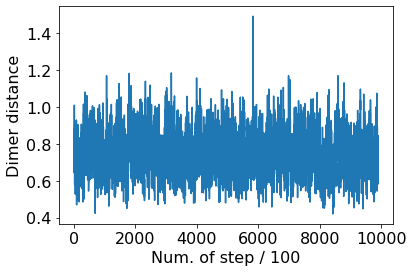

In [11]:
plt.plot(model_flat.dimer_distance(sampler.trajectory))
plt.ylabel("Dimer distance")
plt.xlabel("Num. of step / 100")

In [12]:
B = 18       # height of barrier for normal system
B_flat = 4.5 # height of barrier for this flatenned system
T_roundtrip_lower_bound = N_steps * np.exp(B - B_flat)
print(f"Lower bound for getting roundtrip open-closed state is: {T_roundtrip_lower_bound:e} steps")

Lower bound for getting roundtrip open-closed state is: 7.294164e+11 steps


## Determine optimal length of MC step for best efficiency
This section can be skipped if step is already determined.

In [13]:
x0 = model.init_positions(0.7)
msd = []
sigmas = np.arange(0.005, 0.05, 0.001)
for sigma in sigmas:
    print("Sigma:", sigma)
    sampler = MetropolisGauss(model, x0, sigma_metro=sigma, burn_in=10000, stride=1)
    sampler.run(100000, verbose=10000)
    msd.append(np.mean((sampler.trajectory[1:] - sampler.trajectory[:-1])**2))    

Sigma: 0.005
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.006
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.007
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.008
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.009000000000000001
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000


Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.044
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.045
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.046
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.047
Step 0 / 100000
Step 10000 / 100000
Step 20000 / 100000
Step 30000 / 100000
Step 40000 / 100000
Step 50000 / 100000
Step 60000 / 100000
Step 70000 / 100000
Step 80000 / 100000
Step 90000 / 100000
Sigma: 0.048
Step 0 / 100000
Step 10000 / 10

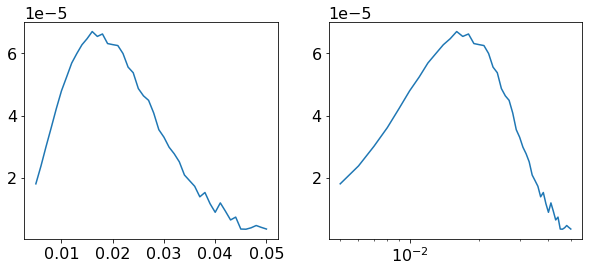

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(sigmas, msd)
axes[1].plot(sigmas, msd)
axes[1].set_xscale("log")

Evaluate free energy with Umbrella Sampling
----

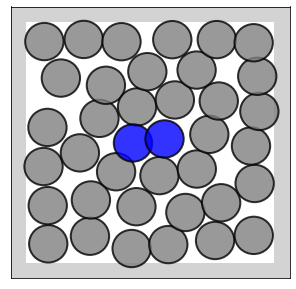

In [15]:
# Create sampler
x0 = model.init_positions(1.0)
sampler = MetropolisGauss(model, x0, sigma_metro=0.02, burn_in=10000, stride=10)
# Relax initial position
sampler.run(10000)
x0 = sampler.x.copy()
# Show relaxed position
model.draw_config(x0, dimer_color='blue', alpha=0.8)

In [16]:
# Umbrella sampling
us = UmbrellaSampling(model, sampler, model.dimer_distance, x0, 35, 1000, 0.5, 2.5, forward_backward=True)
us.run(n_steps=50000, verbose=True)
umbrella_positions = us.umbrella_positions
umbrella_pmf = us.umbrella_free_energies()

Umbrella 1 / 70
Umbrella 2 / 70
Umbrella 3 / 70
Umbrella 4 / 70
Umbrella 5 / 70
Umbrella 6 / 70
Umbrella 7 / 70
Umbrella 8 / 70
Umbrella 9 / 70
Umbrella 10 / 70
Umbrella 11 / 70
Umbrella 12 / 70
Umbrella 13 / 70
Umbrella 14 / 70
Umbrella 15 / 70
Umbrella 16 / 70
Umbrella 17 / 70
Umbrella 18 / 70
Umbrella 19 / 70
Umbrella 20 / 70
Umbrella 21 / 70
Umbrella 22 / 70
Umbrella 23 / 70
Umbrella 24 / 70
Umbrella 25 / 70
Umbrella 26 / 70
Umbrella 27 / 70
Umbrella 28 / 70
Umbrella 29 / 70
Umbrella 30 / 70
Umbrella 31 / 70
Umbrella 32 / 70
Umbrella 33 / 70
Umbrella 34 / 70
Umbrella 35 / 70
Umbrella 36 / 70
Umbrella 37 / 70
Umbrella 38 / 70
Umbrella 39 / 70
Umbrella 40 / 70
Umbrella 41 / 70
Umbrella 42 / 70
Umbrella 43 / 70
Umbrella 44 / 70
Umbrella 45 / 70
Umbrella 46 / 70
Umbrella 47 / 70
Umbrella 48 / 70
Umbrella 49 / 70
Umbrella 50 / 70
Umbrella 51 / 70
Umbrella 52 / 70
Umbrella 53 / 70
Umbrella 54 / 70
Umbrella 55 / 70
Umbrella 56 / 70
Umbrella 57 / 70
Umbrella 58 / 70
Umbrella 59 / 70
Umbrel

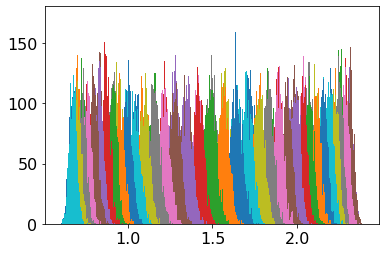

In [17]:
for umbrella_dtraj in us.rc_trajectories:
    plt.hist(umbrella_dtraj, 100);

In [20]:
mbar_positions, mbar_pmf = us.mbar(0.5, 2.5, 35, max_error=1e-3)

../sampling.py:300: RuntimeWarning: divide by zero encountered in log
  F = -np.log(F)


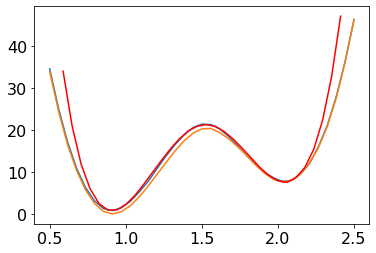

In [22]:
plt.plot(umbrella_positions[:35], umbrella_pmf[:35] - umbrella_pmf.min())
plt.plot(umbrella_positions[35:], umbrella_pmf[35:] - umbrella_pmf.min())
plt.plot(mbar_positions, mbar_pmf, color='red')
#plt.ylim(0, 5)

### Do the same for temperatures $2T$ and $T/2$

In [23]:
class TemperatureModulator:
    def __init__(self, model, temperature_factor):
        self.model = model
        self.temperature_factor = temperature_factor
        self.dim = model.dim
    def energy(self, x):
        return self.model.energy(x) / self.temperature_factor

In [24]:
# US for 2T
model_hot = TemperatureModulator(model, 2.0)
us2 = UmbrellaSampling(model_hot, sampler, model.dimer_distance, x0, 35, 1000, 0.5, 2.5, forward_backward=True)
us2.run(n_steps=50000, verbose=True)
umbrella_positions2 = us2.umbrella_positions
umbrella_pmf2 = us2.umbrella_free_energies()

Umbrella 1 / 70
Umbrella 2 / 70
Umbrella 3 / 70
Umbrella 4 / 70
Umbrella 5 / 70
Umbrella 6 / 70
Umbrella 7 / 70
Umbrella 8 / 70
Umbrella 9 / 70
Umbrella 10 / 70
Umbrella 11 / 70
Umbrella 12 / 70
Umbrella 13 / 70
Umbrella 14 / 70
Umbrella 15 / 70
Umbrella 16 / 70
Umbrella 17 / 70
Umbrella 18 / 70
Umbrella 19 / 70
Umbrella 20 / 70
Umbrella 21 / 70
Umbrella 22 / 70
Umbrella 23 / 70
Umbrella 24 / 70
Umbrella 25 / 70
Umbrella 26 / 70
Umbrella 27 / 70
Umbrella 28 / 70
Umbrella 29 / 70
Umbrella 30 / 70
Umbrella 31 / 70
Umbrella 32 / 70
Umbrella 33 / 70
Umbrella 34 / 70
Umbrella 35 / 70
Umbrella 36 / 70
Umbrella 37 / 70
Umbrella 38 / 70
Umbrella 39 / 70
Umbrella 40 / 70
Umbrella 41 / 70
Umbrella 42 / 70
Umbrella 43 / 70
Umbrella 44 / 70
Umbrella 45 / 70
Umbrella 46 / 70
Umbrella 47 / 70
Umbrella 48 / 70
Umbrella 49 / 70
Umbrella 50 / 70
Umbrella 51 / 70
Umbrella 52 / 70
Umbrella 53 / 70
Umbrella 54 / 70
Umbrella 55 / 70
Umbrella 56 / 70
Umbrella 57 / 70
Umbrella 58 / 70
Umbrella 59 / 70
Umbrel

In [25]:
# US for T/2
model_cold = TemperatureModulator(model, 0.5)
us3 = UmbrellaSampling(model_cold, sampler, model.dimer_distance, x0, 35, 1000, 0.5, 2.5, forward_backward=True)
us3.run(n_steps=50000, verbose=True)
umbrella_positions3 = us3.umbrella_positions
umbrella_pmf3 = us3.umbrella_free_energies()

Umbrella 1 / 70
Umbrella 2 / 70
Umbrella 3 / 70
Umbrella 4 / 70
Umbrella 5 / 70
Umbrella 6 / 70
Umbrella 7 / 70
Umbrella 8 / 70
Umbrella 9 / 70
Umbrella 10 / 70
Umbrella 11 / 70
Umbrella 12 / 70
Umbrella 13 / 70
Umbrella 14 / 70
Umbrella 15 / 70
Umbrella 16 / 70
Umbrella 17 / 70
Umbrella 18 / 70
Umbrella 19 / 70
Umbrella 20 / 70
Umbrella 21 / 70
Umbrella 22 / 70
Umbrella 23 / 70
Umbrella 24 / 70
Umbrella 25 / 70
Umbrella 26 / 70
Umbrella 27 / 70
Umbrella 28 / 70
Umbrella 29 / 70
Umbrella 30 / 70
Umbrella 31 / 70
Umbrella 32 / 70
Umbrella 33 / 70
Umbrella 34 / 70
Umbrella 35 / 70
Umbrella 36 / 70
Umbrella 37 / 70
Umbrella 38 / 70
Umbrella 39 / 70
Umbrella 40 / 70
Umbrella 41 / 70
Umbrella 42 / 70
Umbrella 43 / 70
Umbrella 44 / 70
Umbrella 45 / 70
Umbrella 46 / 70
Umbrella 47 / 70
Umbrella 48 / 70
Umbrella 49 / 70
Umbrella 50 / 70
Umbrella 51 / 70
Umbrella 52 / 70
Umbrella 53 / 70
Umbrella 54 / 70
Umbrella 55 / 70
Umbrella 56 / 70
Umbrella 57 / 70
Umbrella 58 / 70
Umbrella 59 / 70
Umbrel

### Run US for $T/2$ once again since we expet higher error

In [26]:
# US for T/2
model_cold = TemperatureModulator(model, 0.5)
us4 = UmbrellaSampling(model_cold, sampler, model.dimer_distance, x0, 35, 1000, 0.5, 2.5, forward_backward=True)
us4.run(n_steps=50000, verbose=True)
umbrella_positions4 = us4.umbrella_positions
umbrella_pmf4 = us4.umbrella_free_energies()

Umbrella 1 / 70
Umbrella 2 / 70
Umbrella 3 / 70
Umbrella 4 / 70
Umbrella 5 / 70
Umbrella 6 / 70
Umbrella 7 / 70
Umbrella 8 / 70
Umbrella 9 / 70
Umbrella 10 / 70
Umbrella 11 / 70
Umbrella 12 / 70
Umbrella 13 / 70
Umbrella 14 / 70
Umbrella 15 / 70
Umbrella 16 / 70
Umbrella 17 / 70
Umbrella 18 / 70
Umbrella 19 / 70
Umbrella 20 / 70
Umbrella 21 / 70
Umbrella 22 / 70
Umbrella 23 / 70
Umbrella 24 / 70
Umbrella 25 / 70
Umbrella 26 / 70
Umbrella 27 / 70
Umbrella 28 / 70
Umbrella 29 / 70
Umbrella 30 / 70
Umbrella 31 / 70
Umbrella 32 / 70
Umbrella 33 / 70
Umbrella 34 / 70
Umbrella 35 / 70
Umbrella 36 / 70
Umbrella 37 / 70
Umbrella 38 / 70
Umbrella 39 / 70
Umbrella 40 / 70
Umbrella 41 / 70
Umbrella 42 / 70
Umbrella 43 / 70
Umbrella 44 / 70
Umbrella 45 / 70
Umbrella 46 / 70
Umbrella 47 / 70
Umbrella 48 / 70
Umbrella 49 / 70
Umbrella 50 / 70
Umbrella 51 / 70
Umbrella 52 / 70
Umbrella 53 / 70
Umbrella 54 / 70
Umbrella 55 / 70
Umbrella 56 / 70
Umbrella 57 / 70
Umbrella 58 / 70
Umbrella 59 / 70
Umbrel

### Overview of US results

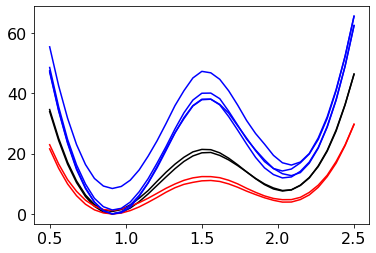

In [27]:
# Normal system
plt.plot(umbrella_positions[:35], umbrella_pmf[:35] - umbrella_pmf.min(), color='black')
plt.plot(umbrella_positions[35:], umbrella_pmf[35:] - umbrella_pmf.min(), color='black')
# Hot system (2T)
plt.plot(umbrella_positions2[:35], umbrella_pmf2[:35] - umbrella_pmf2.min(), color='red')
plt.plot(umbrella_positions2[35:], umbrella_pmf2[35:] - umbrella_pmf2.min(), color='red')
# Cold system (T/2)
plt.plot(umbrella_positions3[:35], umbrella_pmf3[:35] - umbrella_pmf3.min(), color='blue')
plt.plot(umbrella_positions3[35:], umbrella_pmf3[35:] - umbrella_pmf3.min(), color='blue')
plt.plot(umbrella_positions3[:35], umbrella_pmf4[:35] - umbrella_pmf4.min(), color='blue')
plt.plot(umbrella_positions3[35:], umbrella_pmf4[35:] - umbrella_pmf4.min(), color='blue')

## Sample training dataset

In [28]:
def plot_trajectory(etraj, traj):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(etraj)
    axes[0].set_xlabel('Timestep')
    axes[0].set_ylabel('Energy')
    # Dimer distance
    d_traj = np.sqrt((traj[:, 2] - traj[:, 0])**2 + (traj[:, 3] - traj[:, 1])**2)
    axes[1].plot(d_traj)
    axes[1].set_xlabel('Timestep')
    axes[1].set_ylabel('Dimer distance')    
    plt.tight_layout()

In [29]:
n_steps = 5000000
stride = 100
sigma_metro = 0.02
burn_in = 10000
d_closed = 1.0
d_open = 2.0
print_stride = 100000

### Dimer in closed state

In [30]:
# Sample closed
x0 = model.init_positions(d_closed)
sampler_closed = MetropolisGauss(model, x0, sigma_metro=sigma_metro, burn_in=burn_in, stride=stride)
sampler_closed.run(n_steps, verbose=print_stride)

Step 0 / 5000000
Step 100000 / 5000000
Step 200000 / 5000000
Step 300000 / 5000000
Step 400000 / 5000000
Step 500000 / 5000000
Step 600000 / 5000000
Step 700000 / 5000000
Step 800000 / 5000000
Step 900000 / 5000000
Step 1000000 / 5000000
Step 1100000 / 5000000
Step 1200000 / 5000000
Step 1300000 / 5000000
Step 1400000 / 5000000
Step 1500000 / 5000000
Step 1600000 / 5000000
Step 1700000 / 5000000
Step 1800000 / 5000000
Step 1900000 / 5000000
Step 2000000 / 5000000
Step 2100000 / 5000000
Step 2200000 / 5000000
Step 2300000 / 5000000
Step 2400000 / 5000000
Step 2500000 / 5000000
Step 2600000 / 5000000
Step 2700000 / 5000000
Step 2800000 / 5000000
Step 2900000 / 5000000
Step 3000000 / 5000000
Step 3100000 / 5000000
Step 3200000 / 5000000
Step 3300000 / 5000000
Step 3400000 / 5000000
Step 3500000 / 5000000
Step 3600000 / 5000000
Step 3700000 / 5000000
Step 3800000 / 5000000
Step 3900000 / 5000000
Step 4000000 / 5000000
Step 4100000 / 5000000
Step 4200000 / 5000000
Step 4300000 / 5000000
Ste

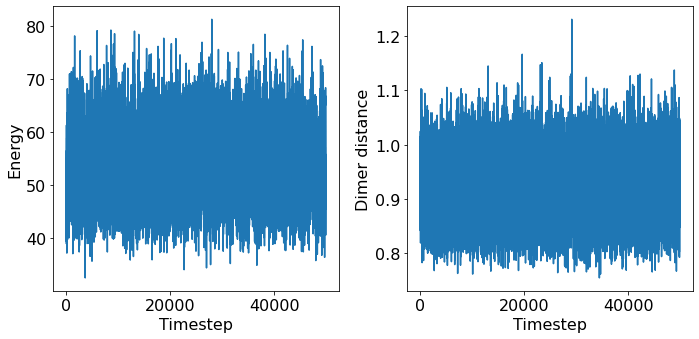

In [31]:
plot_trajectory(sampler_closed.energy_trajectory, sampler_closed.trajectory)

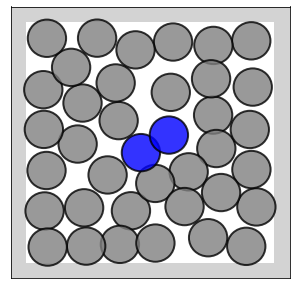

In [32]:
model.draw_config(sampler_closed.trajectory[-1], dimer_color='blue', alpha=0.8);

In [33]:
# Sample again for test dataset
x0 = model.init_positions(d_closed)
sampler_closed2 = MetropolisGauss(model, x0, sigma_metro=sigma_metro, burn_in=burn_in, stride=stride)
sampler_closed2.run(n_steps, verbose=print_stride)

Step 0 / 5000000
Step 100000 / 5000000
Step 200000 / 5000000
Step 300000 / 5000000
Step 400000 / 5000000
Step 500000 / 5000000
Step 600000 / 5000000
Step 700000 / 5000000
Step 800000 / 5000000
Step 900000 / 5000000
Step 1000000 / 5000000
Step 1100000 / 5000000
Step 1200000 / 5000000
Step 1300000 / 5000000
Step 1400000 / 5000000
Step 1500000 / 5000000
Step 1600000 / 5000000
Step 1700000 / 5000000
Step 1800000 / 5000000
Step 1900000 / 5000000
Step 2000000 / 5000000
Step 2100000 / 5000000
Step 2200000 / 5000000
Step 2300000 / 5000000
Step 2400000 / 5000000
Step 2500000 / 5000000
Step 2600000 / 5000000
Step 2700000 / 5000000
Step 2800000 / 5000000
Step 2900000 / 5000000
Step 3000000 / 5000000
Step 3100000 / 5000000
Step 3200000 / 5000000
Step 3300000 / 5000000
Step 3400000 / 5000000
Step 3500000 / 5000000
Step 3600000 / 5000000
Step 3700000 / 5000000
Step 3800000 / 5000000
Step 3900000 / 5000000
Step 4000000 / 5000000
Step 4100000 / 5000000
Step 4200000 / 5000000
Step 4300000 / 5000000
Ste

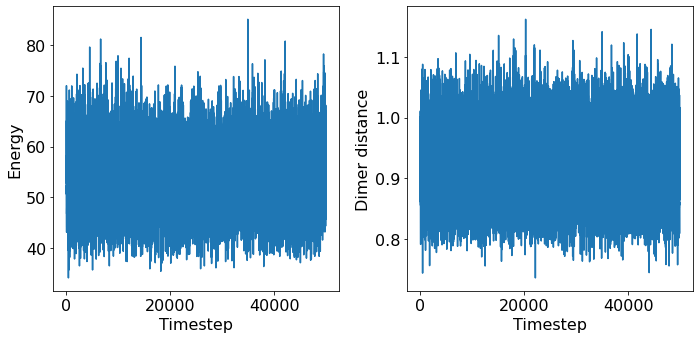

In [34]:
plot_trajectory(sampler_closed2.energy_trajectory, sampler_closed2.trajectory)

### Dimer in opened state

In [35]:
# Sample 
x0 = model.init_positions(d_open)
sampler_open = MetropolisGauss(model, x0, sigma_metro=sigma_metro, burn_in=burn_in, stride=stride)
sampler_open.run(n_steps, verbose=print_stride)

Step 0 / 5000000
Step 100000 / 5000000
Step 200000 / 5000000
Step 300000 / 5000000
Step 400000 / 5000000
Step 500000 / 5000000
Step 600000 / 5000000
Step 700000 / 5000000
Step 800000 / 5000000
Step 900000 / 5000000
Step 1000000 / 5000000
Step 1100000 / 5000000
Step 1200000 / 5000000
Step 1300000 / 5000000
Step 1400000 / 5000000
Step 1500000 / 5000000
Step 1600000 / 5000000
Step 1700000 / 5000000
Step 1800000 / 5000000
Step 1900000 / 5000000
Step 2000000 / 5000000
Step 2100000 / 5000000
Step 2200000 / 5000000
Step 2300000 / 5000000
Step 2400000 / 5000000
Step 2500000 / 5000000
Step 2600000 / 5000000
Step 2700000 / 5000000
Step 2800000 / 5000000
Step 2900000 / 5000000
Step 3000000 / 5000000
Step 3100000 / 5000000
Step 3200000 / 5000000
Step 3300000 / 5000000
Step 3400000 / 5000000
Step 3500000 / 5000000
Step 3600000 / 5000000
Step 3700000 / 5000000
Step 3800000 / 5000000
Step 3900000 / 5000000
Step 4000000 / 5000000
Step 4100000 / 5000000
Step 4200000 / 5000000
Step 4300000 / 5000000
Ste

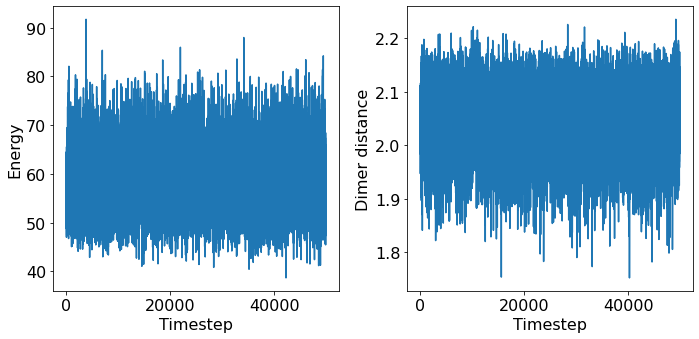

In [36]:
plot_trajectory(sampler_open.energy_trajectory, sampler_open.trajectory)

In [37]:
# Sample again for test dataset
x0 = model.init_positions(d_open)
sampler_open2 = MetropolisGauss(model, x0, sigma_metro=sigma_metro, burn_in=burn_in, stride=stride)
sampler_open2.run(n_steps, verbose=print_stride)

Step 0 / 5000000
Step 100000 / 5000000
Step 200000 / 5000000
Step 300000 / 5000000
Step 400000 / 5000000
Step 500000 / 5000000
Step 600000 / 5000000
Step 700000 / 5000000
Step 800000 / 5000000
Step 900000 / 5000000
Step 1000000 / 5000000
Step 1100000 / 5000000
Step 1200000 / 5000000
Step 1300000 / 5000000
Step 1400000 / 5000000
Step 1500000 / 5000000
Step 1600000 / 5000000
Step 1700000 / 5000000
Step 1800000 / 5000000
Step 1900000 / 5000000
Step 2000000 / 5000000
Step 2100000 / 5000000
Step 2200000 / 5000000
Step 2300000 / 5000000
Step 2400000 / 5000000
Step 2500000 / 5000000
Step 2600000 / 5000000
Step 2700000 / 5000000
Step 2800000 / 5000000
Step 2900000 / 5000000
Step 3000000 / 5000000
Step 3100000 / 5000000
Step 3200000 / 5000000
Step 3300000 / 5000000
Step 3400000 / 5000000
Step 3500000 / 5000000
Step 3600000 / 5000000
Step 3700000 / 5000000
Step 3800000 / 5000000
Step 3900000 / 5000000
Step 4000000 / 5000000
Step 4100000 / 5000000
Step 4200000 / 5000000
Step 4300000 / 5000000
Ste

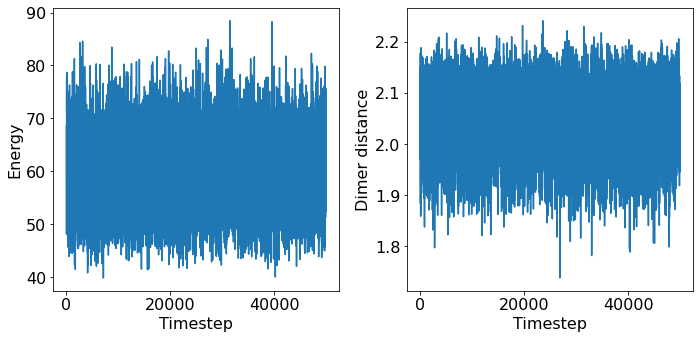

In [38]:
plot_trajectory(sampler_open2.energy_trajectory, sampler_open2.trajectory)

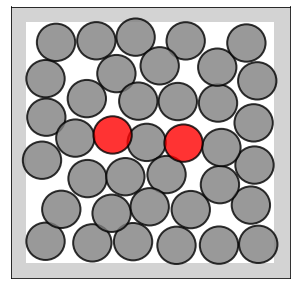

In [39]:
model.draw_config(sampler_open.trajectory[-1], dimer_color='red', alpha=0.8);

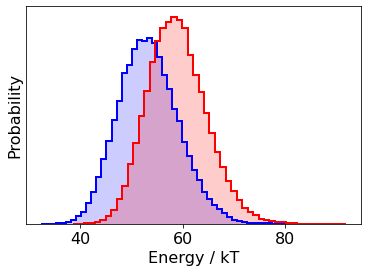

In [40]:
plt.hist(sampler_closed.energy_trajectory, 50, histtype='stepfilled', color='blue', alpha=0.2);
plt.hist(sampler_closed.energy_trajectory, 50, histtype='step', color='blue', linewidth=2);
plt.hist(sampler_open.energy_trajectory, 50, histtype='stepfilled', color='red', alpha=0.2);
plt.hist(sampler_open.energy_trajectory, 50, histtype='step', color='red', linewidth=2);
plt.xlabel('Energy / kT')
plt.yticks([])
plt.ylabel('Probability')
plt.savefig(results_dir + "training_dataset_energy_histogram.png")

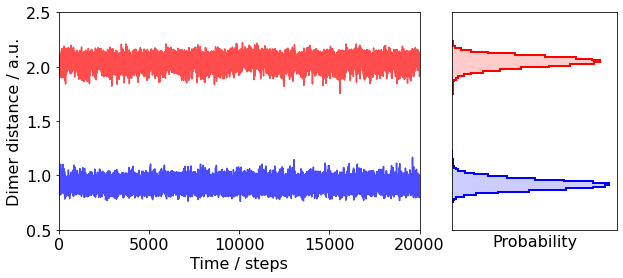

In [41]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(model.dimer_distance(sampler_closed.trajectory), color='blue', alpha=0.7)
ax1.plot(model.dimer_distance(sampler_open.trajectory), color='red', alpha=0.7)
ax1.set_xlim(0, 20000)
ax1.set_ylim(0.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('Dimer distance / a.u.')
ax2.hist(model.dimer_distance(sampler_closed.trajectory), 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2, density=True);
ax2.hist(model.dimer_distance(sampler_closed.trajectory), 30, orientation='horizontal', histtype='step', color='blue', linewidth=2, density=True);
ax2.hist(model.dimer_distance(sampler_open.trajectory), 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2, density=True);
ax2.hist(model.dimer_distance(sampler_open.trajectory), 30, orientation='horizontal', histtype='step', color='red', linewidth=2, density=True);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(0.5, 2.5)
ax2.set_xlabel('Probability')
plt.savefig(results_dir + "training_dataset_dimer_distance.png")

### Check dimer swaps
Check that dimer particles have not exchanged their positions.

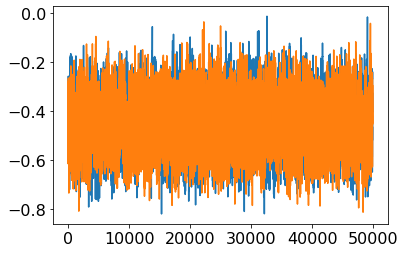

In [42]:
plt.plot(sampler_closed.trajectory[:, 0])
plt.plot(sampler_closed2.trajectory[:, 0])

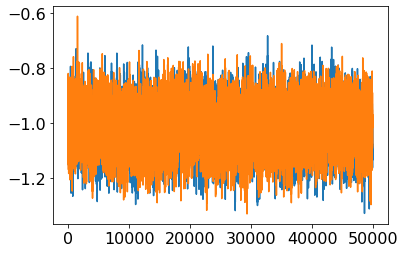

In [43]:
plt.plot(sampler_open.trajectory[:, 0])
plt.plot(sampler_open2.trajectory[:, 0])

Particle permutation identity
----

In [44]:
mapper = HungarianMapper(
    1.05*model.init_positions(1.5), 
    dim=2, 
    identical_particles=np.arange(2, model.n_particles)
)

Remove particle diffusion.

In [45]:
traj_closed_train_hungarian = mapper.map(sampler_closed.trajectory)
traj_open_train_hungarian = mapper.map(sampler_open.trajectory)
traj_closed_test_hungarian = mapper.map(sampler_closed2.trajectory)
traj_open_test_hungarian = mapper.map(sampler_open2.trajectory)

Save data
----

In [46]:
# Store trajectory data
trajdict = {}
trajdict['params'] = model.params
trajdict['traj_closed_train'] = sampler_closed.trajectory
trajdict['traj_open_train'] = sampler_open.trajectory
trajdict['traj_closed_train_hungarian'] = traj_closed_train_hungarian
trajdict['traj_open_train_hungarian'] = traj_open_train_hungarian
trajdict['etraj_closed_train'] = sampler_closed.energy_trajectory
trajdict['etraj_open_train'] = sampler_open.energy_trajectory
trajdict['traj_closed_test'] = sampler_closed2.trajectory
trajdict['traj_open_test'] = sampler_open2.trajectory
trajdict['traj_closed_test_hungarian'] = traj_closed_test_hungarian
trajdict['traj_open_test_hungarian'] = traj_open_test_hungarian
trajdict['etraj_closed_test'] = sampler_closed2.energy_trajectory
trajdict['etraj_open_test'] = sampler_open2.energy_trajectory

In [47]:
# Store data from umbrella sampling
us_dict = {}
us_dict['umbrella_positions'] = us.umbrella_positions
us_dict['umbrella_FE'] = umbrella_pmf
us_dict['mbar_positions'] = mbar_positions
us_dict['mbar_FE'] = mbar_pmf

us_dict['umbrella_FE_hot'] = umbrella_pmf2
us_dict['umbrella_FE_cold_1'] = umbrella_pmf3
us_dict['umbrella_FE_cold_2'] = umbrella_pmf

In [48]:
directory = '../resources/'
np.savez_compressed(directory + 'bistable_dimer_training_data.npz', **trajdict)
np.savez_compressed(directory + 'bistable_dimer_umbrella_sampling_data.npz', **us_dict)